In [1]:
# Import necessary libraries
# Handle data frames
import pandas as pd
# Handle geo data frames (data frames with geometry)
import geopandas as gpd
# Operations on geometries
import shapely
from shapely import speedups
# Fast vectorized operations
import shapely.vectorized as sv
# Arrays and maths
import numpy as np
import math
# Handle netCDF4 data
import xarray as xr
# Plotting
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set()
%matplotlib inline

In [36]:
# Path to dataset
path = "..."
# Load precipitation data (here a netcdf4 .nc file) using xarray
prec_data = xr.open_dataset(path + "./daily_precip.nc")

# Load HydroBASIN data (shapefile .shp) using geopandas
# HydroBASIN data can be downloaded from HydroSHEDS page: https://www.hydrosheds.org/downloads
hybas_data = gpd.read_file(path +
    "./hybas_lake_au_lev01-06_v1c/hybas_lake_au_lev06_v1c.shp")

In [37]:
# Select the necessary subset of columns from HydroBASIN dataframe
hybas_data_gdf = hybas_data[['HYBAS_ID',
                             'SUB_AREA', 'LAKE', 'COAST', 'ENDO', 'geometry']]

In [40]:
# Find the min/max longitude and latitude of the HydroBASIN catchments set
# to be used as boundaries for the lon/lat grid creation
lon_min = math.floor(hybas_data.total_bounds[0])
lon_max = math.ceil(hybas_data.total_bounds[2])
lat_min = math.floor(hybas_data.total_bounds[1])
lat_max = math.ceil(hybas_data.total_bounds[3])
# Set the grid points resolution corresponding to the precipitation data (important!)
dl = 0.25
nlon = 360/dl
nlat = 180/dl
# Grid construction
lons, lats = np.mgrid[lon_min:lon_max:dl, lat_min:lat_max+dl:dl]
lons, lats = lons.T.flatten(), lats.T.flatten()
# Array to store the catchment ids (HYBAS_ID) containing the (lon,lat) point
basin_id = np.zeros(len(lons))
data_f = np.column_stack((basin_id, lons, lats))

In [41]:
# For each grid point of data_f, find which catchment of hybas_data is containing it
for i in hybas_data_gdf.index:
    data_f[sv.contains(hybas_data_gdf.geometry[i], x=lons,
                       y=lats), 0] = hybas_data_gdf.HYBAS_ID[i]

In [42]:
# Select only catchments containing at least 1 grid point
data_temp = pd.DataFrame(data=data_f[data_f[:, 0] > 0], columns=[
                         'HYBAS_ID', 'lon', 'lat'])
# Compute the number of grid points (NP) inside each catchment
data_temp['NP'] = data_temp.groupby('HYBAS_ID')['HYBAS_ID'].transform('count')

In [43]:
# Save the catchment-grid points data for further use (optional step)
# NB: this step is optional but it's recommended to set the dtype as in data_f2
# to reduce memory usage and speed up the execution
data_temp.to_csv('Catchments_Grid_AU_lv6.csv', header=True,
                 encoding='utf-8', index=False)
# Load it back
data_f2 = pd.read_csv('Catchments_Grid_AU_lv6.csv', dtype={'HYBAS_ID': 'int64',
                                                           'lon': 'float32', 'lat': 'float32', 'NP': 'int32'})

In [46]:
# Select catchments containing at least np grid points (optional step)
np = 5
data_f2 = data_f2[data_f2.NP >= np]
#data_f2.drop(['NP'], axis=1, inplace=True)

In [ ]:
# Reduce precipitation data based on the boundaries of the set of catchments
lon_min = data_f2['lon'].min()
lon_max = data_f2['lon'].max()
lat_min = data_f2['lat'].min()
lat_max = data_f2['lat'].max()
prec_data_sel = prec_data.TP.sel(
    lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

In [22]:
# Loop over all time step of precipitation data to calculate aggregated precipitation by catchment
# as the mean of the grid points values inside a catchment
# A loop structure is used to load a limited amount of data in memory at each step (prec data can be large)
for i in range(0, len(prec_data_sel.time)):
    prec_data_temp = prec_data_sel.isel(time=i).to_dataframe()
    prec_data_temp.reset_index(inplace=True)
    prec_data_temp = prec_data_temp.astype(
        {'lon': 'float32', 'lat': 'float32'})
    hybas_prec_final = pd.merge(data_f2, prec_data_temp, on=[
                                'lon', 'lat'], how='inner')
    hybas_prec_final.drop(['lat', 'lon'], axis=1, inplace=True)
    hybas_prec_by_basin = hybas_prec_final.groupby(['HYBAS_ID', 'time']).mean()
    hybas_prec_by_basin.reset_index(inplace=True)
    hybas_prec_by_basin['time'] = hybas_prec_by_basin['time'].dt.date
    if i == 0:
        hybas_prec_by_basin.to_csv(
            'PR_BASIN_SA_lv6.csv', header=True, encoding='utf-8', index=False)
    else:
        hybas_prec_by_basin.to_csv(
            'PR_BASIN_SA_lv6.csv', mode='a', header=False, encoding='utf-8', index=False)

In [ ]:
# Select catchments in the midlatitudes (20°-70°N/S) with 99th quantile > 10[mm]
hybas_data_gdf_midlatNH = hybas_data_gdf[(
    hybas_data_gdf.bounds.miny > 20) & (hybas_data_gdf.bounds.maxy < 70)]
hybas_data_gdf_midlatSH = hybas_data_gdf[(
    hybas_data_gdf.bounds.miny < -20) & (hybas_data_gdf.bounds.maxy > -70)]
hybas_data_gdf_midlat = hybas_data_gdf_midlatNH.append(hybas_data_gdf_midlatSH)
hybas_data_gdf_midlat['x_c'] = hybas_data_gdf_midlat.geometry.centroid.x
hybas_data_gdf_midlat['y_c'] = hybas_data_gdf_midlat.geometry.centroid.y
hybas_data_gdf_midlat['x_min'] = hybas_data_gdf_midlat.bounds.minx
hybas_data_gdf_midlat['x_max'] = hybas_data_gdf_midlat.bounds.maxx
# The next step requires the quantiles to be computed
# cf. the "Compute quantiles" section in subseasonal_clustering_article.R
filepaths = [path2 + "/" +
             f for f in listdir(path2) if f.startswith('quantiles')]
qnts = pd.concat(map(pd.read_csv, filepaths))
qnts_gdf_midlat = pd.merge(hybas_data_gdf_midlat, qnts, on=[
                           'HYBAS_ID'], how='inner')
qnts_gdf_midlat_TP10 = qnts_gdf_midlat[(
    qnts_gdf_midlat.Threshold == "t99") & (qnts_gdf_midlat.TP > 10)]
qnts_gdf_midlat_TP10sel = qnts_gdf_midlat_TP10[[
    'HYBAS_ID', 'x_c', 'y_c', 'x_min', 'x_max', 'Threshold', 'TP']]
qnts_gdf_midlat_TP10sel.rename(
    columns={'Threshold': 'Th', 'TP': 'Th_val'}, inplace=True)
# This selection file is then used back in the R script to compute clustering episodes only on selected catchments,
# this reduces computational time
qnts_gdf_midlat_TP10sel.to_csv(
    'Catchments_midlat_TP10.csv', header=True, encoding='utf-8', index=False)

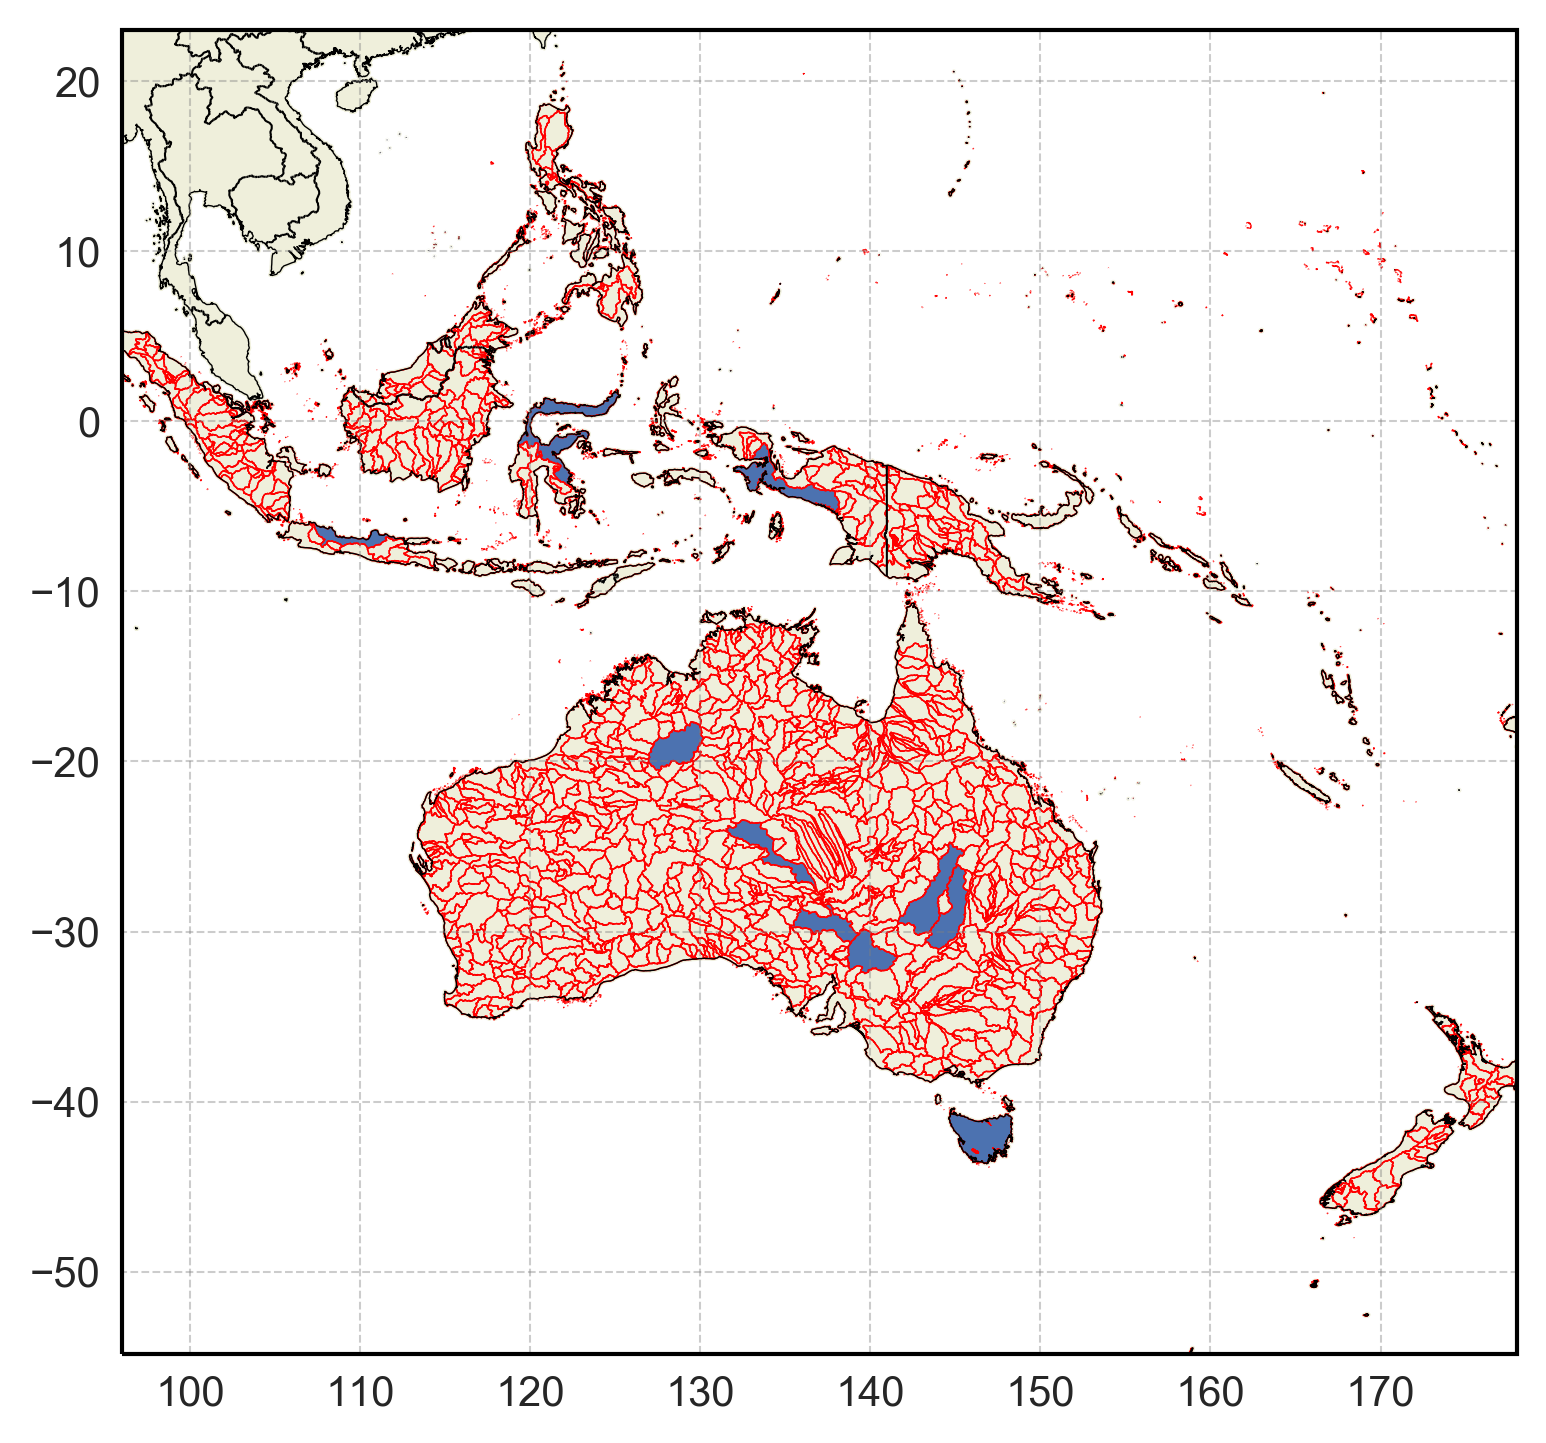

In [47]:
# Example plot selected catchments in blue (based on NP)
mask = #insert a list of catchments (HYBAS_ID)
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(6, 6), dpi=300)
ax = plt.axes(projection=projection)
lon_min = data_f2['lon'].min()
lon_max = data_f2['lon'].max()
lat_min = data_f2['lat'].min()
lat_max = data_f2['lat'].max()

# Plot a selection of catchments based on mask (default color = blue)
hybas_data_gdf.loc[hybas_data_gdf.HYBAS_ID.isin(
    mask)].geometry.plot(ax=ax, edgecolor='none')

# Plot all catchments boundaries in red
hybas_data_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=0.33)

# Cartopy features
ax.add_feature(cfeature.COASTLINE.with_scale(
    '10m'), linestyle='-', linewidth=0.33)
ax.add_feature(cfeature.BORDERS.with_scale(
    '10m'), linestyle='-', linewidth=0.5)
ax.add_feature(cfeature.LAND.with_scale('10m'))
#ax.add_feature(cfeature.OCEAN.with_scale('10m'), zorder=10)

# Focus on region of interest
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

gl = ax.gridlines(crs=projection, draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.4, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False